In [1]:
from datasets import PointDataset
from models import MLPCNF
from lightning import Trainer
from lightning.pytorch.callbacks import RichModelSummary

In [2]:
dataset = PointDataset(dim=3)
model = MLPCNF(dim=dataset.dim, hidden_dim=128, depth=4, lr=3e-4)
# model = torch.compile(model)

train_dataloader = dataset.dataloader(
    batch_size=1024,
    batches=256,
    num_workers=32,
    persistent_workers=True,
    pin_memory=True,
)
trainer = Trainer(
    accelerator="cpu",
    max_epochs=10,
    callbacks=[RichModelSummary()],
)
trainer.fit(model, train_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/davide_sartor/.conda/envs/torch_env/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


┏━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩
│ 0 │ flow │ MLP  │ 51.7 K │
└───┴──────┴──────┴────────┘

Trainable params: 51.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 51.7 K                                                                                               
Total estimated model params size (MB): 0

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/1 [00:00<?, ?it/s]

Pushing data through flow


100%|██████████| 16/16 [00:01<00:00, 12.33it/s]


Running MCMC sampling


100%|██████████| 300/300 [00:00<00:00, 348.39it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:01<00:00, 350.03it/s]


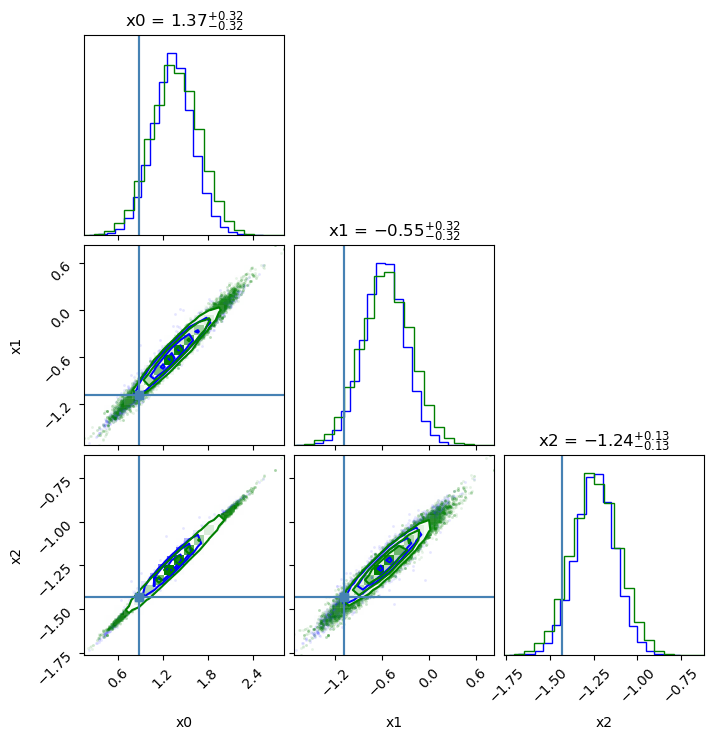

In [3]:
from utils import corner_plot
corner_plot(dataset, model, examples=1, ode_steps=16, samples=32*1024, verbose=True)